训练后的策略：


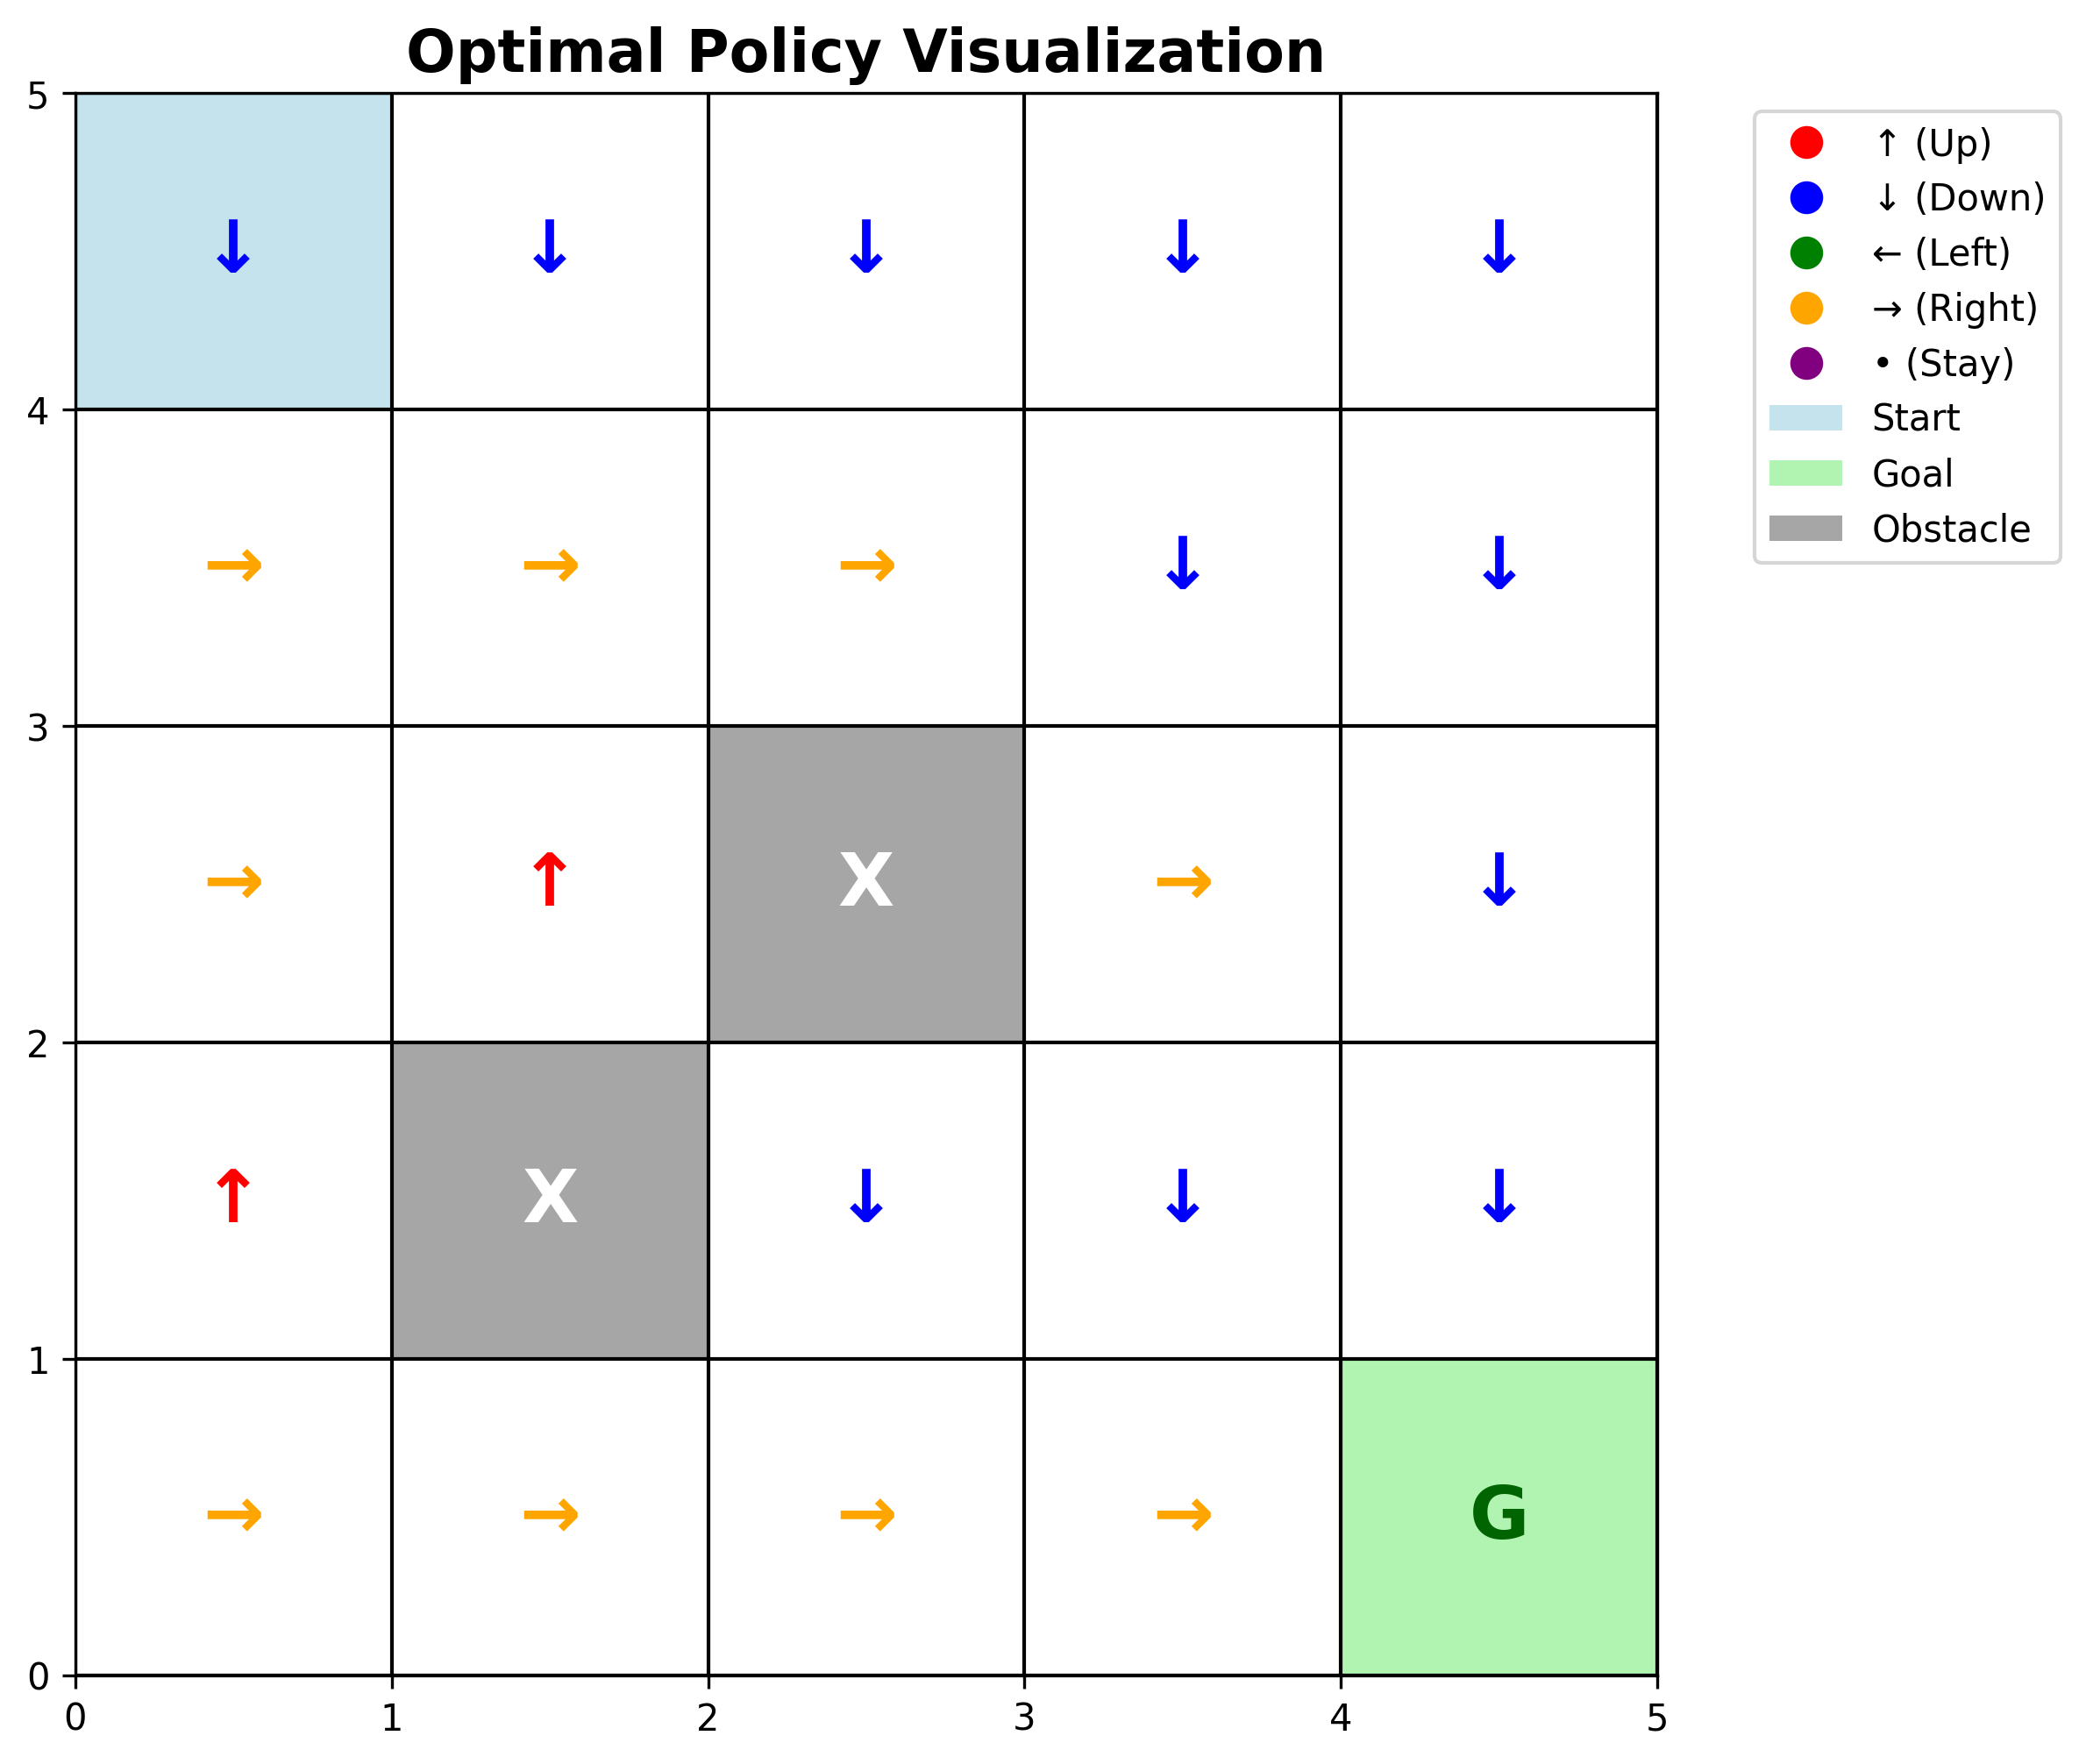

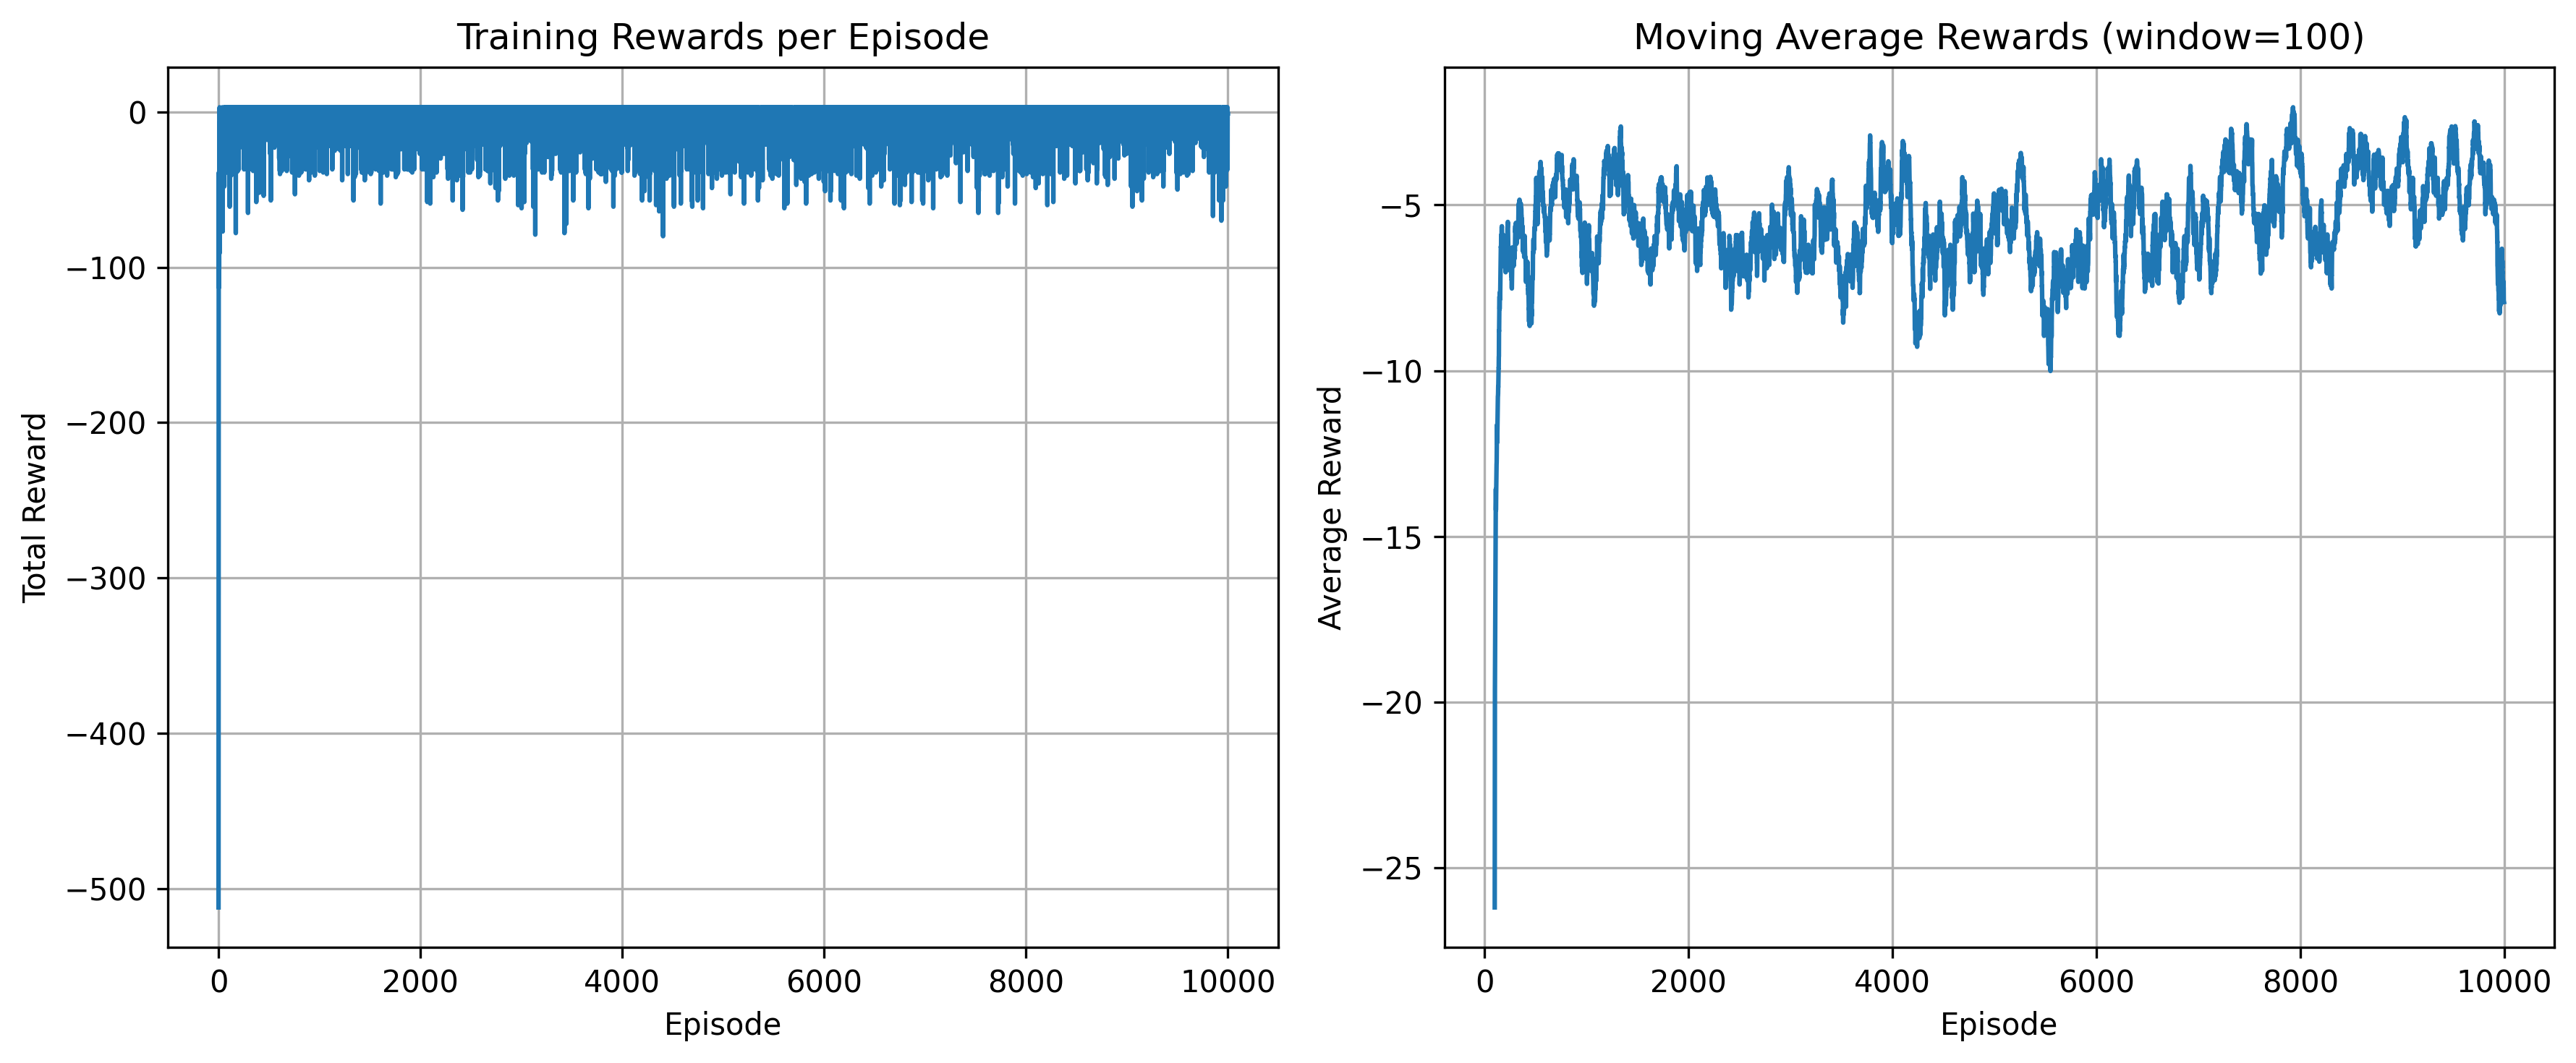

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 定义网格世界环境
class GridWorld:
    def __init__(self):
        self.n_rows = 5
        self.n_cols = 5
        self.start = (0, 0)
        self.goal = (4, 4)
        # 定义障碍物
        self.obstacles = [(2, 2), (3, 1)]
        self.state = self.start

    def reset(self):
        """重置环境至起点"""
        self.state = self.start
        return self.state

    def step(self, action):
        """
        执行动作
        动作：0: 上, 1: 下, 2: 左, 3: 右, 4: 原地不动
        返回：下一个状态, 奖励, 是否结束
        
        为防止出界，所有移动动作都会在边界处被限制在有效范围内。
        """
        x, y = self.state
        
        # 根据动作计算下一个状态，并利用边界检查确保不出界
        if action == 0:  # 上
            next_state = (max(x - 1, 0), y)
        elif action == 1:  # 下
            next_state = (min(x + 1, self.n_rows - 1), y)
        elif action == 2:  # 左
            next_state = (x, max(y - 1, 0))
        elif action == 3:  # 右
            next_state = (x, min(y + 1, self.n_cols - 1))
        elif action == 4:  # 原地不动
            next_state = (x, y)
        else:
            next_state = self.state

        # 如果试图出界（虽然由于边界检查不可能发生），则保持原状态
        if next_state == self.state and action != 4:
            # 可以选择额外惩罚出界动作，但此处统一奖励为 -1
            reward = -20
            done = False
        # 判断是否进入障碍物
        elif next_state in self.obstacles:
            reward = -10
            # 撞到障碍物后保持原状态
            next_state = self.state
            done = False
        elif next_state == self.goal:
            reward = 10
            done = True
        else:
            reward = -1
            done = False

        self.state = next_state
        return next_state, reward, done

    def get_possible_actions(self):
        """返回所有可能的动作（包含原地不动）"""
        return [0, 1, 2, 3, 4]


# Q-learning 算法实现
def train_agent(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.2):
    # 初始化 Q 表：每个状态下的 5 个动作的 Q 值初始化为 0
    Q = {}
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            Q[(i, j)] = np.zeros(5)
    
    rewards_per_episode = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # ε-greedy 策略选择动作
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.get_possible_actions())
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            # Q-learning 更新公式
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            
            state = next_state
        
        rewards_per_episode.append(total_reward)
        # 可选：打印每一集的总奖励，观察收敛过程
        # print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    
    return Q, rewards_per_episode


# 输出策略函数：用箭头表示最优动作
def print_policy(Q, env):
    actions_map = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '•'}
    grid_policy = []
    for i in range(env.n_rows):
        row = []
        for j in range(env.n_cols):
            if (i, j) in env.obstacles:
                row.append('X')  # 障碍物用 X 表示
            elif (i, j) == env.goal:
                row.append('G')  # 目标状态用 G 表示
            else:
                action = np.argmax(Q[(i, j)])
                row.append(actions_map[action])
        grid_policy.append(row)
    
    for row in grid_policy:
        print(' '.join(row))


# 绘制训练过程中的reward曲线
def plot_rewards(rewards_per_episode, window_size=100):
    plt.figure(figsize=(12, 5),dpi = 300)
    
    # 原始奖励曲线
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Training Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    # 滑动平均奖励曲线
    plt.subplot(1, 2, 2)
    if len(rewards_per_episode) >= window_size:
        moving_avg = np.convolve(rewards_per_episode, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(rewards_per_episode)), moving_avg)
        plt.title(f'Moving Average Rewards (window={window_size})')
    else:
        plt.plot(rewards_per_episode)
        plt.title('Training Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# 主程序入口
if __name__ == '__main__':
    env = GridWorld()
    Q, rewards = train_agent(env, episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.2)
    print("训练后的策略：")
    # 可视化策略函数：用图像展示最优策略
    def visualize_policy(Q, env):
        actions_map = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '•'}
        colors_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple'}
        
        fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
        
        # 创建网格
        for i in range(env.n_rows + 1):
            ax.axhline(i, color='black', linewidth=1)
        for j in range(env.n_cols + 1):
            ax.axvline(j, color='black', linewidth=1)
        
        # 绘制每个格子的内容
        for i in range(env.n_rows):
            for j in range(env.n_cols):
                x, y = j + 0.5, env.n_rows - i - 0.5  # 转换坐标系
                
                if (i, j) in env.obstacles:
                    # 障碍物用灰色方块表示
                    ax.add_patch(plt.Rectangle((j, env.n_rows - i - 1), 1, 1, 
                                             facecolor='gray', alpha=0.7))
                    ax.text(x, y, 'X', ha='center', va='center', 
                           fontsize=20, fontweight='bold', color='white')
                elif (i, j) == env.goal:
                    # 目标用绿色方块表示
                    ax.add_patch(plt.Rectangle((j, env.n_rows - i - 1), 1, 1, 
                                             facecolor='lightgreen', alpha=0.7))
                    ax.text(x, y, 'G', ha='center', va='center', 
                           fontsize=20, fontweight='bold', color='darkgreen')
                elif (i, j) == env.start:
                    # 起点用蓝色方块表示
                    ax.add_patch(plt.Rectangle((j, env.n_rows - i - 1), 1, 1, 
                                             facecolor='lightblue', alpha=0.7))
                    action = np.argmax(Q[(i, j)])
                    ax.text(x, y, actions_map[action], ha='center', va='center', 
                           fontsize=20, fontweight='bold', color=colors_map[action])
                else:
                    # 普通格子显示最优动作
                    action = np.argmax(Q[(i, j)])
                    ax.text(x, y, actions_map[action], ha='center', va='center', 
                           fontsize=20, fontweight='bold', color=colors_map[action])
        
        ax.set_xlim(0, env.n_cols)
        ax.set_ylim(0, env.n_rows)
        ax.set_aspect('equal')
        ax.set_title('Optimal Policy Visualization', fontsize=16, fontweight='bold')
        ax.set_xticks(range(env.n_cols + 1))
        ax.set_yticks(range(env.n_rows + 1))
        
        # 添加图例
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='↑ (Up)'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='↓ (Down)'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='← (Left)'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='→ (Right)'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='• (Stay)'),
            plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', alpha=0.7, label='Start'),
            plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', alpha=0.7, label='Goal'),
            plt.Rectangle((0, 0), 1, 1, facecolor='gray', alpha=0.7, label='Obstacle')
        ]
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        plt.tight_layout()
        plt.show()

    visualize_policy(Q, env)
    
    # 绘制奖励曲线
    plot_rewards(rewards)
